# Import Packages

In [11]:
import pandas as pd
import numpy as np
import os
import time
import keyboard
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
DURATION = 10  # Duration for keystroke data collection
KEY_HOLD = 'hold_time'
KEY_RELEASE = 'release_time'
TYPING_SPEED = 'typing_speed'

# Data Collection

In [4]:
def collect_keystroke_data(prompt):
    print(prompt)
    keystrokes = []
    start_time = time.time()
    while time.time() - start_time < DURATION:
        event = keyboard.read_event(suppress=True)
        timestamp = time.time()
        keystrokes.append((event, timestamp))
    return keystrokes

# Feature Extraction

In [5]:
def extract_features(keystrokes):
    features = []
    for i in range(1, len(keystrokes)):
        prev_event, prev_timestamp = keystrokes[i - 1]
        event, timestamp = keystrokes[i]

        if event.event_type == keyboard.KEY_DOWN and prev_event.event_type == keyboard.KEY_DOWN:
            hold_time = timestamp - prev_timestamp
            release_time = 0  # Not applicable for key down events
            typing_speed = 0  # Not applicable for key down events
        elif event.event_type == keyboard.KEY_UP and prev_event.event_type == keyboard.KEY_DOWN:
            hold_time = 0  # Not applicable for key up events
            release_time = timestamp - prev_timestamp
            typing_speed = 1 / (timestamp - prev_timestamp)
        else:
            continue

        features.append({
            KEY_HOLD: hold_time,
            KEY_RELEASE: release_time,
            TYPING_SPEED: typing_speed
        })

    return features

# Save & load data into CSV

In [6]:
def save_data_to_csv(dataframe, filename='keystroke_data.csv'):
    if os.path.exists(filename):
        dataframe.to_csv(filename, mode='a', header=False, index=False)
    else:
        dataframe.to_csv(filename, mode='w', header=True, index=False)
    print("Data saved to CSV.")

In [7]:
def load_data_from_csv(filename='keystroke_data.csv'):
    return pd.read_csv(filename)

# Train Neural Network Model

In [47]:
def train_nn_from_csv(filename='keystroke_data.csv'):
    # Load the data
    dataframe = load_data_from_csv(filename)

    # Prepare data for training
    X = dataframe.drop(['Name'], axis=1)
    y = dataframe['Name']
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
    
    # Neural network architecture
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(y_categorical.shape[1], activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Callback to save the best model
    checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
    
    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[checkpoint])
    
    # Evaluate the model
    best_model = load_model('model.keras')
    _, accuracy = best_model.evaluate(X_test, y_test)
    print("Model trained successfully from CSV data.")
    print("Model accuracy:", accuracy)
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    
    # Accuracy
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    
    # Loss
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Save the encoder and the model architecture
    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)

# Executation

In [15]:
def execute():
    users_data = []
    while True:
        name = input("Enter your name: ")
        keystrokes = collect_keystroke_data(f"Collecting {name}'s data. Please type your password:")
        features = extract_features(keystrokes)
        
        users_data.append({'Name': name, 'Features': features})
        
        if input("Press Enter to add another user or type 'done' to finish: ").lower() == 'done':
            break
    flattened_data = []
    for item in users_data:
        name = item['Name']
        for feature in item['Features']:
            feature['Name'] = name
            flattened_data.append(feature)
    df = pd.DataFrame(flattened_data)
    save_data_to_csv(df)
    return df

# Data Visualization

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_keystroke_data(filename='keystroke_data.csv'):
    df = pd.read_csv(filename)
    
    # Plot histograms for hold time, release time, and typing speed
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    sns.histplot(df[KEY_HOLD], bins=30, kde=True, ax=axs[0])
    axs[0].set_title('Hold Time Distribution')
    sns.histplot(df[KEY_RELEASE], bins=30, kde=True, ax=axs[1])
    axs[1].set_title('Release Time Distribution')
    sns.histplot(df[TYPING_SPEED], bins=30, kde=True, ax=axs[2])
    axs[2].set_title('Typing Speed Distribution')
    
    plt.tight_layout()
    plt.show()

In [34]:
def plot_user_comparison(filename='keystroke_data.csv'):
    df = pd.read_csv(filename)
    
    # Use seaborn's pairplot to create a scatter plot matrix with histograms, colored by user
    pair_plot = sns.pairplot(df, hue='Name', markers=["o", "s", "D", "^"], 
                             plot_kws={'alpha': 0.5}, diag_kind="hist",
                             diag_kws={'alpha':0.7, 'bins':20})
    pair_plot.fig.suptitle('Comparison of Keystroke Dynamics by User', y=1.02)
    plt.show()

In [27]:
def plot_user_feature_comparison(filename='keystroke_data.csv'):
    df = pd.read_csv(filename)
    
    # Calculate mean values of features grouped by user
    user_means = df.groupby('Name').mean().reset_index()
    
    # Plotting the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.25
    index = np.arange(len(user_means['Name']))
    
    bars1 = ax.bar(index, user_means[KEY_HOLD], bar_width, label='Hold Time')
    bars2 = ax.bar(index + bar_width, user_means[KEY_RELEASE], bar_width, label='Release Time')
    bars3 = ax.bar(index + 2 * bar_width, user_means[TYPING_SPEED], bar_width, label='Typing Speed')
    
    ax.set_xlabel('User')
    ax.set_ylabel('Average Values')
    ax.set_title('Average Keystroke Dynamics by User')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(user_means['Name'])
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# The function call is commented out to adhere to the instruction guidelines.
# Uncomment the following line for execution in your environment:

In [17]:
def plot_training_history(history):
    # Plotting the accuracy and loss graphs
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    
    # Accuracy
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    
    # Loss
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Collect Data 
`Use only if you want to add more data`

In [36]:
execute()

Enter your name:  user1


Press Enter to add another user or type 'done' to finish:  user1
Enter your name:  user1


Press Enter to add another user or type 'done' to finish:  
Enter your name:  user2


Press Enter to add another user or type 'done' to finish:  user2
Enter your name:  user2


Press Enter to add another user or type 'done' to finish:  done


Data saved to CSV.


,hold_time,release_time,typing_speed,Name
0,0.000000,0.136202,7.342044,user1
1,0.000000,0.115052,8.691687,user1
2,0.000000,0.118807,8.416990,user1
3,0.000000,0.109165,9.160429,user1
4,0.000000,0.128653,7.772858,user1
5,0.000000,0.124604,8.025425,user1
6,0.000000,0.128444,7.785511,user1
7,0.000000,0.124593,8.026132,user1
8,0.000000,0.100063,9.993695,user1
9,0.000000,0.117289,8.525927,user1


# Visual Insights from the data

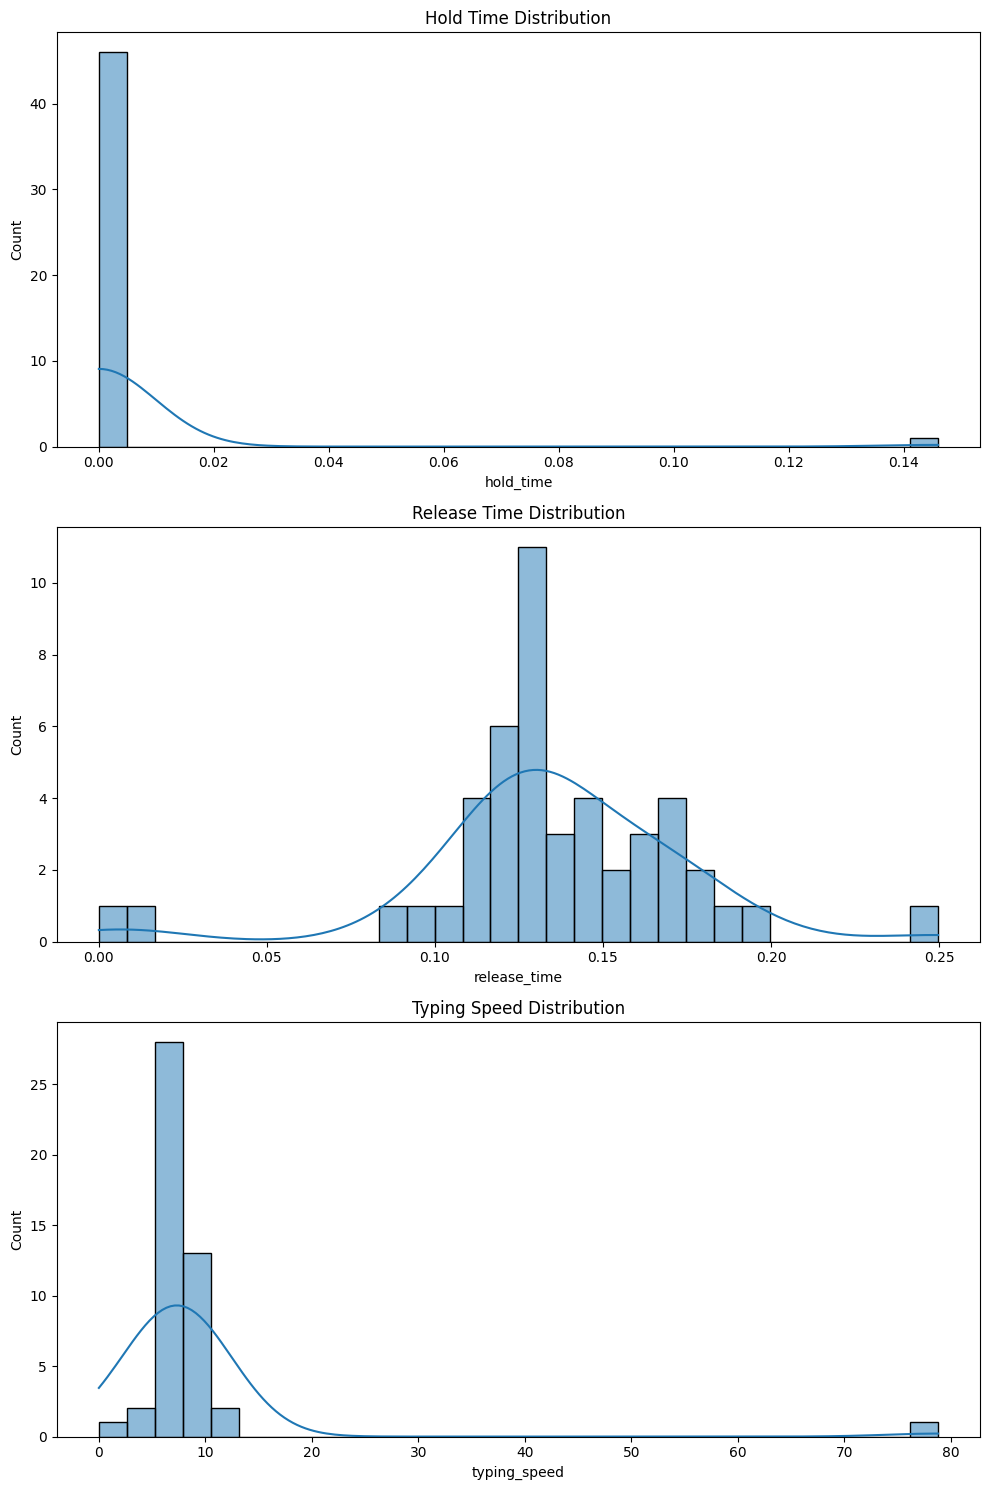

In [38]:
plot_keystroke_data()

C:\Users\Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning

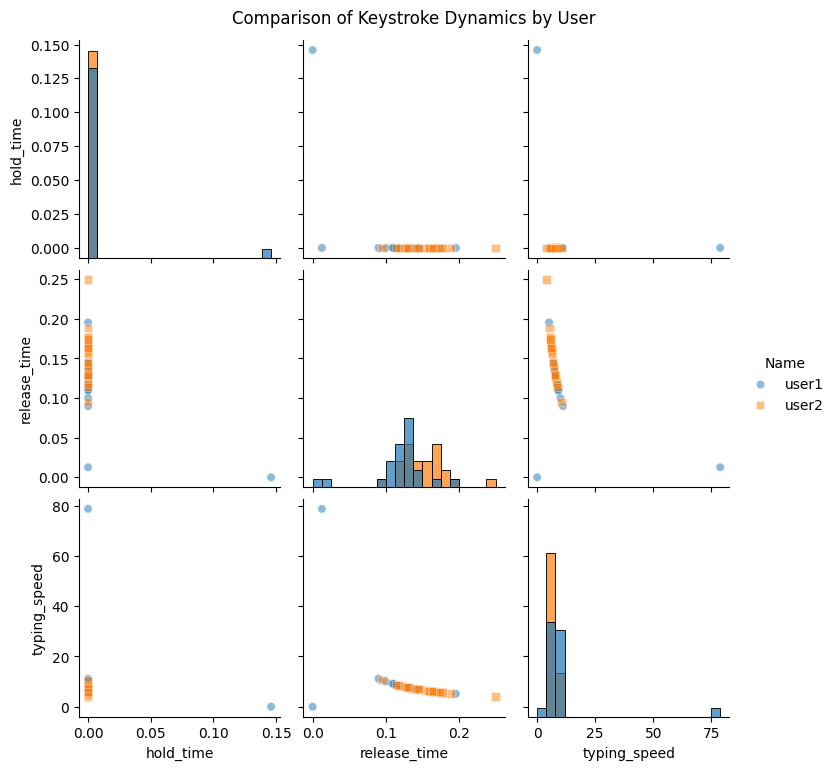

In [39]:
plot_user_comparison() 

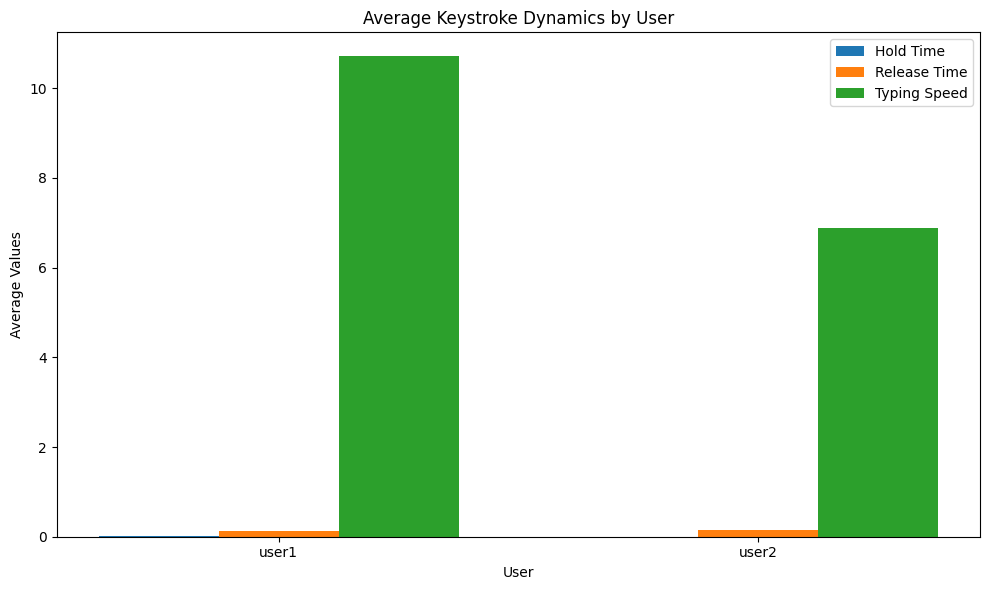

In [40]:
plot_user_feature_comparison()

# Run the Model

Epoch 1/50


C:\Users\Mohamed\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - accuracy: 0.5194 - loss: 0.6995 - val_accuracy: 0.2000 - val_loss: 0.7064
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5166 - loss: 0.6822 - val_accuracy: 0.3000 - val_loss: 0.7963
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5374 - loss: 0.7185 - val_accuracy: 0.3000 - val_loss: 0.9276
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5479 - loss: 0.7606 - val_accuracy: 0.3000 - val_loss: 0.8792
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5479 - loss: 0.7431 - val_accuracy: 0.3000 - val_loss: 0.7443
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5479 - loss: 0.6933 - val_accuracy: 0.3000 - val_loss: 0.6908
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5659 - loss: 0.6889 - val_accuracy: 0.7000 - val_loss: 0.9150
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4910 - loss: 0.7205 - val_accuracy: 0.7000 - val_loss: 1.0116
Epoch 9/50

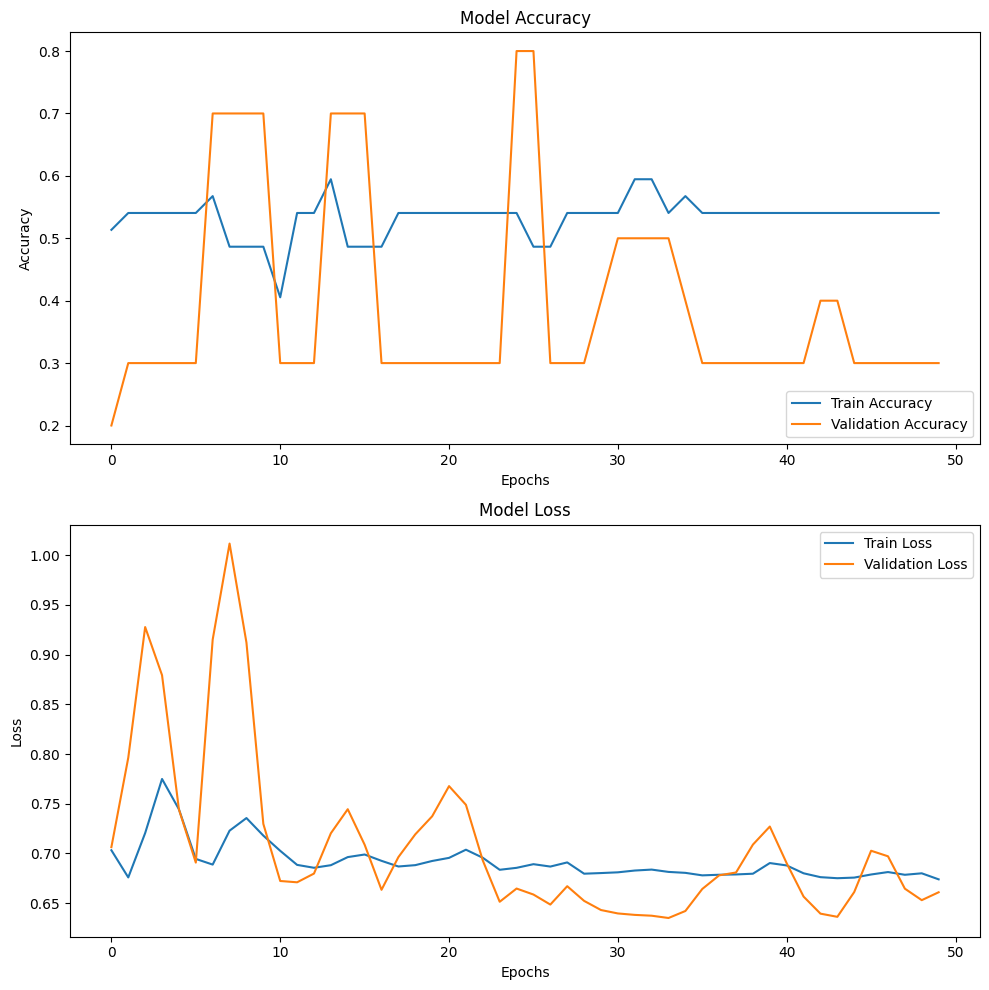

In [48]:
train_nn_from_csv()